In [1]:
import os
import glob
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms


In [2]:
from torch.autograd import Variable


class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [3]:
class Horse2ZebraDataset(Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.root = root
        self.mode = mode
        self.transform = transform
        
        if mode == 'train':
            self.horse_files = glob.glob(os.path.join(root, 'trainA', '*.jpg'))
            self.zebra_files = glob.glob(os.path.join(root, 'trainB', '*.jpg'))
        elif mode == 'test':
            self.horse_files = glob.glob(os.path.join(root, 'testA', '*.jpg'))
            self.zebra_files = glob.glob(os.path.join(root, 'testB', '*.jpg'))
        else:
            raise ValueError("mode should be either 'train' or 'test'")

    def __len__(self):
        return max(len(self.horse_files), len(self.zebra_files))

    def __getitem__(self, index):
        horse_path = self.horse_files[index % len(self.horse_files)]
        zebra_path = self.zebra_files[index % len(self.zebra_files)]

        horse_image = Image.open(horse_path).convert('RGB')
        zebra_image = Image.open(zebra_path).convert('RGB')

        if self.transform:
            horse_image = self.transform(horse_image)
            zebra_image = self.transform(zebra_image)

        return horse_image, zebra_image

In [24]:
transforms_ = [
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataset = Horse2ZebraDataset(
    './datasets/horse2zebra',
    mode='train',
    transform=transforms.Compose(transforms_)
)

test_dataset = Horse2ZebraDataset(
    './datasets/horse2zebra',
    mode='test',
    transform=transforms.Compose(transforms_)
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.pad1 = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3)
        self.in1 = nn.InstanceNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.pad2 = nn.ReflectionPad2d(1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3)
        self.in2 = nn.InstanceNorm2d(256)

    def forward(self, x):
        res = x
        x = self.pad1(x)
        x = self.conv1(x)
        x = self.in1(x)
        x = self.relu(x)
        x = self.pad2(x)
        x = self.conv2(x)
        x = self.in2(x)
        return x + res

**generative network**
- 3개의 합성곱 레이어
- 여러 개의 잔차 블록 (128*128: 6블록, 256*256: 9블록)
- 2개의 Fractionally strided convolution 레이어(stride: 1/2)
- RGB로 특성 매핑을 위한 1개의 합성곱 레이어
- 인스턴스 정규화 사용

**구체적인 레이아웃**

The network with 9 residual blocks consists of:  
c7s1-64,d128,d256,R256,R256,R256,  
R256,R256,R256,R256,R256,R256,u128  
u64,c7s1-3

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.pad1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7)
        self.in1 = nn.InstanceNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.in2 = nn.InstanceNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.in3 = nn.InstanceNorm2d(256)

        # 잔차 블록 수 결정 (256x256 이미지에 맞춰 9개)
        num_blocks = 9
        self.residual_blocks = nn.Sequential(*[ResidualBlock() for _ in range(num_blocks)])
        
        self.us1 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.in4 = nn.InstanceNorm2d(128)
        
        self.us2 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.in5 = nn.InstanceNorm2d(64)
        
        self.pad2 = nn.ReflectionPad2d(3)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=7)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.pad1(x)
        x = self.conv1(x)
        x = self.in1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.in2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.in3(x)
        x = self.relu(x)

        x = self.residual_blocks(x)
        
        x = self.us1(x)
        x = self.conv4(x)
        x = self.in4(x)
        x = self.relu(x)
        
        x = self.us2(x)
        x = self.conv5(x)
        x = self.in5(x)
        x = self.relu(x)
        
        x = self.pad2(x)
        x = self.conv6(x)
        x = self.tanh(x)
        return x

**discriminator networks**

70 × 70 PatchGAN의 discriminator 부분 사용

**구체적인 레이아웃**
Ck: 4*4 Convolution-InstanceNorm-LeakyReLU (k filters, stride 2)

C64-C128-C256-C512  


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.in2 = nn.InstanceNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.in3 = nn.InstanceNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.in4 = nn.InstanceNorm2d(512)

        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.in2(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.in3(x)
        x = self.leaky_relu(x)

        x = self.conv4(x)
        x = self.in4(x)
        x = self.leaky_relu(x)

        x = self.zero_pad(x)
        x = self.conv5(x)
        return x

> Weights are initialized from a Gaussian distribution N (0, 0.02).

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [9]:
import itertools

from torch.optim.lr_scheduler import LambdaLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')

G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

lambda_cycle = 10.0
lambda_identity = 0.5
num_epochs = 10

opt_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
opt_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lr_lambda = lambda epoch: 1.0 - max(0, epoch + 0 - 100) / (num_epochs - 100)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(opt_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(opt_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(opt_D_B, lr_lambda=lr_lambda)

criterion_GAN = torch.nn.MSELoss().to(device)
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [11]:
import tqdm


G_losses = []
D_A_losses = []
D_B_losses = []

for epoch in range(num_epochs):
    for i, (horses, zebras) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        real_A = horses.to(device)
        real_B = zebras.to(device)
        
        # Train generators
        G_AB.train()
        G_BA.train()
        
        opt_G.zero_grad()
        
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total loss
        loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity
        loss_G.backward()
        opt_G.step()
        
        # Train discriminator A
        opt_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        opt_D_A.step()
        
        # Train discriminator B
        opt_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        opt_D_B.step()
        
        G_losses.append(loss_G.item())
        D_A_losses.append(loss_D_A.item())
        D_B_losses.append(loss_D_B.item())
        
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    

    print(f"Epoch [{epoch}/{num_epochs}], G Loss: {loss_G.item()}, D_A Loss: {loss_D_A.item()}, D_B Loss: {loss_D_B.item()}")

100%|██████████| 1334/1334 [08:17<00:00,  2.68it/s]


Epoch [0/10], G Loss: 3.819228410720825, D_A Loss: 0.33338403701782227, D_B Loss: 0.05886001139879227


100%|██████████| 1334/1334 [08:17<00:00,  2.68it/s]


Epoch [1/10], G Loss: 1.6968964338302612, D_A Loss: 0.26864853501319885, D_B Loss: 0.2862033247947693


100%|██████████| 1334/1334 [08:17<00:00,  2.68it/s]


Epoch [2/10], G Loss: 2.6065664291381836, D_A Loss: 0.13369110226631165, D_B Loss: 0.45836424827575684


100%|██████████| 1334/1334 [08:13<00:00,  2.70it/s]


Epoch [3/10], G Loss: 2.146707534790039, D_A Loss: 0.27459388971328735, D_B Loss: 0.3326566517353058


100%|██████████| 1334/1334 [08:14<00:00,  2.70it/s]


Epoch [4/10], G Loss: 3.0494332313537598, D_A Loss: 0.19162443280220032, D_B Loss: 0.15377654135227203


100%|██████████| 1334/1334 [08:14<00:00,  2.70it/s]


Epoch [5/10], G Loss: 2.44770884513855, D_A Loss: 0.2788369059562683, D_B Loss: 0.24780718982219696


100%|██████████| 1334/1334 [08:13<00:00,  2.70it/s]


Epoch [6/10], G Loss: 2.026838541030884, D_A Loss: 0.1523178070783615, D_B Loss: 0.37045520544052124


100%|██████████| 1334/1334 [08:15<00:00,  2.69it/s]


Epoch [7/10], G Loss: 4.284327507019043, D_A Loss: 0.13341455161571503, D_B Loss: 0.12103608250617981


100%|██████████| 1334/1334 [08:16<00:00,  2.69it/s]


Epoch [8/10], G Loss: 2.281972646713257, D_A Loss: 0.10713137686252594, D_B Loss: 0.024522986263036728


100%|██████████| 1334/1334 [08:15<00:00,  2.69it/s]

Epoch [9/10], G Loss: 2.423058271408081, D_A Loss: 0.07337039709091187, D_B Loss: 0.056295767426490784


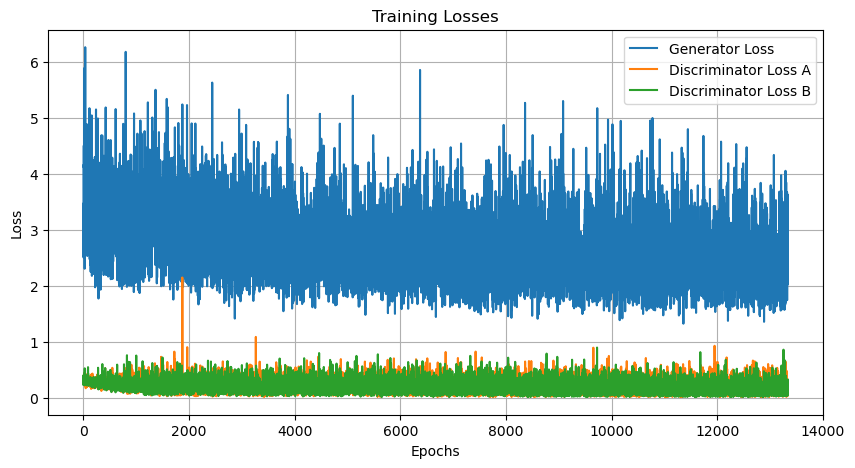

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_A_losses, label='Discriminator Loss A')
plt.plot(D_B_losses, label='Discriminator Loss B')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


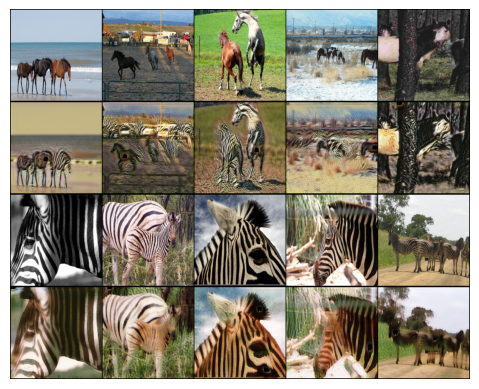

In [25]:
from torchvision.utils import make_grid

def sample_images():
    real_A, real_B = next(iter(test_loader))
    real_A = real_A.type(torch.float32).to(device)
    real_B = real_B.type(torch.float32).to(device)
    G_AB.eval()
    G_BA.eval()
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    image_grid = image_grid.permute(1, 2, 0)
    plt.imshow(image_grid.cpu().numpy())
    plt.axis('off')
    plt.show()

sample_images()